<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#library-import" data-toc-modified-id="library-import-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>library import</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#저장" data-toc-modified-id="저장-1.0.1"><span class="toc-item-num">1.0.1&nbsp;&nbsp;</span>저장</a></span></li></ul></li></ul></li></ul></div>

In [2]:
from lightgbm import LGBMRegressor
LGBMRegressor().get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

# library import

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
# 한글 사용
plt.rc('font', family='NanumBarunGothic')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.filterwarnings(action='ignore')

In [4]:
path = '235743_구내식당 식사 인원 예측 AI 경진대회_data/'
train = pd.read_csv(path + 'train.csv')
test = pd.read_csv(path + 'test.csv')
submission = pd.read_csv(path + 'sample_submission.csv')

In [5]:
# 석식 이용 인원 0인 날 삭제
train = train[train['석식계'] != 0]

# 요일 숫자로 변경
train.loc[train['요일'] == '월', '요일'] = 1
train.loc[train['요일'] == '화', '요일'] = 2
train.loc[train['요일'] == '수', '요일'] = 3
train.loc[train['요일'] == '목', '요일'] = 4
train.loc[train['요일'] == '금', '요일'] = 5

# 월 칼럼 추가
def month(text:str):
    return int(text[5:7])
train['월'] = train['일자'].map(month)

# 일 칼럼 추가
def day(text:str):
    return int(text[-2:])
train['일'] = train['일자'].map(day)

# 현재원 컬럼 추가
train['현재원'] = train['본사정원수'] - (train['본사휴가자수']+train['본사출장자수']+train['현본사소속재택근무자수'])

train.head()


# 요일 숫자로 변경
test.loc[test['요일'] == '월', '요일'] = 1
test.loc[test['요일'] == '화', '요일'] = 2
test.loc[test['요일'] == '수', '요일'] = 3
test.loc[test['요일'] == '목', '요일'] = 4
test.loc[test['요일'] == '금', '요일'] = 5

# 월 칼럼 추가
test['월'] = test['일자'].map(month)

# 일 칼럼 추가
test['일'] = test['일자'].map(day)

# 현재원 컬럼 추가
test['현재원'] = test['본사정원수'] - (test['본사휴가자수']+test['본사출장자수']+test['현본사소속재택근무자수'])

test.head()




# 주피터의 f 코랩에서는 Ctrl Shift H

,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,중식계,석식계,월,일,현재원
0,2016-02-01,1,2601,50,150,238,0.0,모닝롤/찐빵 우유/두유/주스 계란후라이 호두죽/쌀밥 (쌀:국내산) 된장찌개 쥐...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 오징어찌개 쇠불고기 (쇠고기:호주산) 계란찜 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 육개장 자반고등어구이 두부조림 건파래무침 ...",1039.0,331.0,2,1,2401.0
1,2016-02-02,2,2601,50,173,319,0.0,모닝롤/단호박샌드 우유/두유/주스 계란후라이 팥죽/쌀밥 (쌀:국내산) 호박젓국찌...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 김치찌개 가자미튀김 모둠소세지구이 마늘쫑무...","콩나물밥*양념장 (쌀,현미흑미:국내산) 어묵국 유산슬 (쇠고기:호주산) 아삭고추무...",867.0,560.0,2,2,2378.0
2,2016-02-03,3,2601,56,180,111,0.0,모닝롤/베이글 우유/두유/주스 계란후라이 표고버섯죽/쌀밥 (쌀:국내산) 콩나물국...,"카레덮밥 (쌀,현미흑미:국내산) 팽이장국 치킨핑거 (닭고기:국내산) 쫄면야채무침 ...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 청국장찌개 황태양념구이 (황태:러시아산) 고기...",1017.0,573.0,2,3,2365.0
3,2016-02-04,4,2601,104,220,355,0.0,"모닝롤/토마토샌드 우유/두유/주스 계란후라이 닭죽/쌀밥 (쌀,닭:국내산) 근대국...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 쇠고기무국 주꾸미볶음 부추전 시금치나물 ...","미니김밥*겨자장 (쌀,현미흑미:국내산) 우동 멕시칸샐러드 군고구마 무피클 포...",978.0,525.0,2,4,2277.0
4,2016-02-05,5,2601,278,181,34,0.0,모닝롤/와플 우유/두유/주스 계란후라이 쇠고기죽/쌀밥 (쌀:국내산) 재첩국 방...,"쌀밥/잡곡밥 (쌀,현미흑미:국내산) 떡국 돈육씨앗강정 (돼지고기:국내산) 우엉잡채...","쌀밥/잡곡밥 (쌀,현미흑미:국내산) 차돌박이찌개 (쇠고기:호주산) 닭갈비 (닭고기:...",925.0,330.0,2,5,2142.0


,일자,요일,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,조식메뉴,중식메뉴,석식메뉴,월,일,현재원
0,2021-01-27,3,2983,88,182,5,358.0,모닝롤/연유버터베이글 우유/주스 계란후라이/찐계란 단호박죽/흑미밥 우거지국 고기완자...,쌀밥/흑미밥/찰현미밥 대구지리 매운돈갈비찜 오꼬노미계란말이 상추무침 포기김치 양상추...,흑미밥 얼큰순두부찌개 쇠고기우엉볶음 버섯햄볶음 (New)아삭이고추무절임 포기김치,1,27,2355.0
1,2021-01-28,4,2983,104,212,409,348.0,모닝롤/대만샌드위치 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 황태국 시래기지짐 ...,쌀밥/보리밥/찰현미밥 우렁된장찌개 오리주물럭 청양부추전 수제삼색무쌈 겉절이김치 양상...,충무김밥 우동국물 오징어무침 꽃맛살샐러드 얼갈이쌈장무침 석박지,1,28,2319.0
2,2021-01-29,5,2983,270,249,0,294.0,모닝롤/핫케익 우유/주스 계란후라이/찐계란 오곡죽/흑미밥 매생이굴국 고구마순볶음 양...,쌀밥/흑미밥/찰현미밥 팽이장국 수제돈까스*소스 가자미조림 동초나물무침 포기김치 양상...,흑미밥 물만둣국 카레찜닭 숯불양념꼬지어묵 꼬시래기무침 포기김치,1,29,2170.0
3,2021-02-01,1,2924,108,154,538,322.0,모닝롤/촉촉한치즈케익 우유/주스 계란후라이/찐계란 누룽지탕/흑미밥 두부김칫국 새우완...,쌀밥/흑미밥/찰현미밥 배추들깨국 오리대패불고기 시금치프리타타 부추고추장무침 포기김치...,흑미밥 동태탕 돈육꽈리고추장조림 당면채소무침 모자반무침 포기김치,2,1,2340.0
4,2021-02-02,2,2924,62,186,455,314.0,모닝롤/토마토샌드 우유/주스 계란후라이/찐계란 채소죽/흑미밥 호박맑은국 오이생채 양...,쌀밥/팥밥/찰현미밥 부대찌개 닭살데리야끼조림 버섯탕수 세발나물무침 알타리김치/사과푸...,흑미밥 바지락살국 쇠고기청경채볶음 두부구이*볶은김치 머위된장무침 백김치,2,2,2362.0


In [22]:
# 고기
train.loc[(train['조식메뉴'].str.contains('쇠'))|(train['조식메뉴'].str.contains('소'))|(train['조식메뉴'].str.contains('고기'))|
          (train['조식메뉴'].str.contains('돼지'))|(train['조식메뉴'].str.contains('돈육'))|
          (train['조식메뉴'].str.contains('닭'))|(train['조식메뉴'].str.contains('치킨'))|
          (train['조식메뉴'].str.contains('오리')), '조식메뉴'] = 1
train.loc[train['조식메뉴']!=1, '조식메뉴'] = 0
test.loc[(test['조식메뉴'].str.contains('쇠'))|(test['조식메뉴'].str.contains('소'))|(test['조식메뉴'].str.contains('고기'))|
          (test['조식메뉴'].str.contains('돼지'))|(test['조식메뉴'].str.contains('돈육'))|
          (test['조식메뉴'].str.contains('닭'))|(test['조식메뉴'].str.contains('치킨'))|
          (test['조식메뉴'].str.contains('오리')), '조식메뉴'] = 1
test.loc[test['조식메뉴']!=1, '조식메뉴'] = 0

# int 형으로 바꾸기
train['조식메뉴'] = train['조식메뉴'].map(int)
test['조식메뉴'] = test['조식메뉴'].map(int)

In [23]:
# 고기
# train[train['중식메뉴'].contains('고기')]
# (train.loc[train['중식메뉴'].str.contains('고기'), '중식메뉴']).count()
train.shape
# train.loc[train['중식메뉴'].str.contains('고기'), '중식메뉴']
train.loc[(train['중식메뉴'].str.contains('쇠'))|(train['중식메뉴'].str.contains('소'))|(train['중식메뉴'].str.contains('고기'))|
          (train['중식메뉴'].str.contains('돼지'))|(train['중식메뉴'].str.contains('돈육'))|
          (train['중식메뉴'].str.contains('닭'))|(train['중식메뉴'].str.contains('치킨'))|
          (train['중식메뉴'].str.contains('오리')), '중식메뉴'] = 1
train.loc[train['중식메뉴']!=1, '중식메뉴'] = 0
# train.loc[(train['중식메뉴'].str.contains('돼지'))|(train['중식메뉴'].str.contains('돈육')), '중식메뉴']
# train.loc[(train['중식메뉴'].str.contains('닭'))|(train['중식메뉴'].str.contains('치킨')), '중식메뉴']
# train.loc[(train['중식메뉴'].str.contains('오리')), '중식메뉴']

test.loc[(test['중식메뉴'].str.contains('쇠'))|(test['중식메뉴'].str.contains('소'))|(test['중식메뉴'].str.contains('고기'))|
          (test['중식메뉴'].str.contains('돼지'))|(test['중식메뉴'].str.contains('돈육'))|
          (test['중식메뉴'].str.contains('닭'))|(test['중식메뉴'].str.contains('치킨'))|
          (test['중식메뉴'].str.contains('오리')), '중식메뉴'] = 1
test.loc[test['중식메뉴']!=1, '중식메뉴'] = 0

# int 형으로 바꾸기
train['중식메뉴'] = train['중식메뉴'].map(int)
test['중식메뉴'] = test['중식메뉴'].map(int)

(1162, 15)

In [24]:
# 고기
train.loc[(train['석식메뉴'].str.contains('쇠'))|(train['석식메뉴'].str.contains('소'))|(train['석식메뉴'].str.contains('고기'))|
          (train['석식메뉴'].str.contains('돼지'))|(train['석식메뉴'].str.contains('돈육'))|
          (train['석식메뉴'].str.contains('닭'))|(train['석식메뉴'].str.contains('치킨'))|
          (train['석식메뉴'].str.contains('오리')), '석식메뉴'] = 1
train.loc[train['석식메뉴']!=1, '석식메뉴'] = 0

test.loc[(test['석식메뉴'].str.contains('쇠'))|(test['석식메뉴'].str.contains('소'))|(test['석식메뉴'].str.contains('고기'))|
          (test['석식메뉴'].str.contains('돼지'))|(test['석식메뉴'].str.contains('돈육'))|
          (test['석식메뉴'].str.contains('닭'))|(test['석식메뉴'].str.contains('치킨'))|
          (test['석식메뉴'].str.contains('오리')), '석식메뉴'] = 1
test.loc[test['석식메뉴']!=1, '석식메뉴'] = 0

# int 형으로 바꾸기
train['석식메뉴'] = train['석식메뉴'].map(int)
test['석식메뉴'] = test['석식메뉴'].map(int)

In [25]:
train['요일'] = train['요일'].astype(int)
test['요일'] = test['요일'].astype(int)
train['현본사소속재택근무자수'] = train['현본사소속재택근무자수'].astype(int)
test['현본사소속재택근무자수'] = test['현본사소속재택근무자수'].astype(int)
train['현재원'] = train['현재원'].astype(int)
test['현재원'] = test['현재원'].astype(int)
train['중식계'] = train['중식계'].astype(int)
train['석식계'] = train['석식계'].astype(int)
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1162 entries, 0 to 1204
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   일자              1162 non-null   object
 1   요일              1162 non-null   int64 
 2   본사정원수           1162 non-null   int64 
 3   본사휴가자수          1162 non-null   int64 
 4   본사출장자수          1162 non-null   int64 
 5   본사시간외근무명령서승인건수  1162 non-null   int64 
 6   현본사소속재택근무자수     1162 non-null   int64 
 7   조식메뉴            1162 non-null   int64 
 8   중식메뉴            1162 non-null   int64 
 9   석식메뉴            1162 non-null   int64 
 10  중식계             1162 non-null   int64 
 11  석식계             1162 non-null   int64 
 12  월               1162 non-null   int64 
 13  일               1162 non-null   int64 
 14  현재원             1162 non-null   int64 
dtypes: int64(14), object(1)
memory usage: 145.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 14

In [7]:
from sklearn.model_selection import GridSearchCV
# from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

params = {
    'learning_rate': [0.1, 0.01, 0.001],
    'boosting_type': ['gbdt', 'rf', 'dart'],
    'n_estimators': [200, 300],
    
    'random_state':[0, 41, 42] # , 43, 44, 45, 46, 47, 48, 49, 50, 51, 56
    
} # , 'goss' 'max_depth': [30, 50, 60],


lunch_r = LGBMRegressor(objective='regression')
lunch_model = GridSearchCV(lunch_r, params, scoring='neg_mean_absolute_error', verbose = 10)

dinner_r = LGBMRegressor(objective='regression')
dinner_model = GridSearchCV(dinner_r, params, scoring='neg_mean_absolute_error', verbose = 10)

In [53]:
####### 이거 실행했음
features = ['요일', '월', '일', '현재원', '본사휴가자수',
      '본사출장자수', '본사시간외근무명령서승인건수',
      '현본사소속재택근무자수', '중식메뉴']
features

X = train[features]
y = train['중식계']

lunch_model.fit(X,y)
print(lunch_model.best_score_, lunch_model.best_params_)
lunch_model = lunch_model.best_estimator_



# 석식계
# features.append('중식계')
features.extend(['중식계', '석식메뉴'])

test['중식계'] = lunch_count_predict

X = train[features]
y = train['석식계']

dinner_model.fit(X,y)
print(dinner_model.best_score_, dinner_model.best_params_)
dinner_model = dinner_model.best_estimator_


['요일',
 '월',
 '일',
 '현재원',
 '본사휴가자수',
 '본사출장자수',
 '본사시간외근무명령서승인건수',
 '현본사소속재택근무자수',
 '중식메뉴']

LGBMRegressor(boosting_type='goss', learning_rate=0.001, max_depth=50,
              n_estimators=300, n_jobs=32, objective='regression',
              random_state=42)

AttributeError: 'LGBMRegressor' object has no attribute 'best_params_'

In [10]:
train[features]

,요일,월,일,현재원,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수
0,1,2,1,2401.0,50,150,238,0.0
1,2,2,2,2378.0,50,173,319,0.0
2,3,2,3,2365.0,56,180,111,0.0
3,4,2,4,2277.0,104,220,355,0.0
4,5,2,5,2142.0,278,181,34,0.0
...,...,...,...,...,...,...,...,...
1200,3,1,20,2319.0,75,198,4,391.0
1201,4,1,21,2309.0,92,231,462,351.0
1202,5,1,22,2177.0,255,248,1,303.0
1203,1,1,25,2396.0,107,153,616,327.0


In [94]:
LGBMRegressor().get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

['요일',
 '월',
 '일',
 '현재원',
 '본사휴가자수',
 '본사출장자수',
 '본사시간외근무명령서승인건수',
 '현본사소속재택근무자수',
 '중식메뉴']

LGBMRegressor(learning_rate=0.001, max_depth=300, n_estimators=5000, n_jobs=32,
              objective='regression', random_state=41, reg_alpha=0.05)

<Figure size 900x600 with 0 Axes>

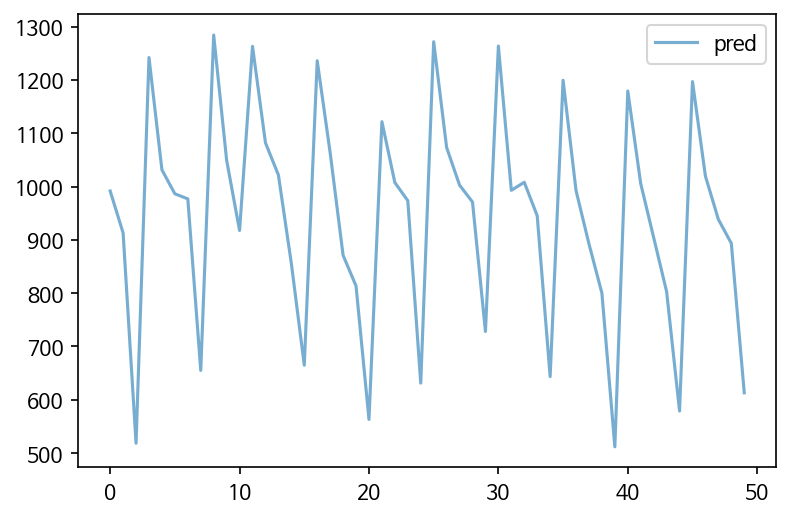

LGBMRegressor(boosting_type='goss', learning_rate=0.0009, max_depth=300,
              n_estimators=5000, n_jobs=32, objective='regression',
              random_state=50, reg_alpha=0.05)

<Figure size 900x600 with 0 Axes>

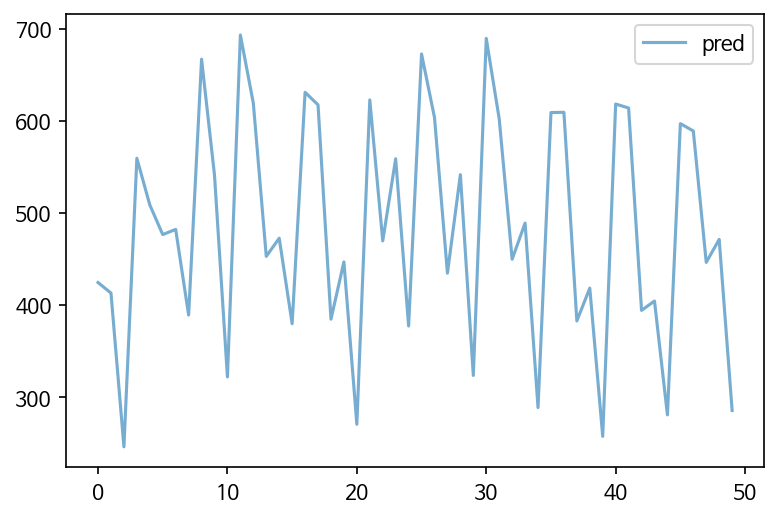

In [105]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# features = ['요일', '월', '일', '현재원', '본사휴가자수',
#       '본사출장자수', '본사시간외근무명령서승인건수',
#       '현본사소속재택근무자수']

features = ['요일', '월', '일', '현재원', '본사휴가자수',
      '본사출장자수', '본사시간외근무명령서승인건수',
      '현본사소속재택근무자수', '중식메뉴']
features

X = train[features]
y = train['중식계']

lunch_model = LGBMRegressor(n_jobs = 32, random_state = 41, objective='regression', boosting_type= 'gbdt',
                            learning_rate= 0.001, n_estimators = 5000, max_depth = 300,
                           reg_alpha = 0.05)
lunch_model.fit(X,y)

lunch_count_predict = lunch_model.predict(test[features])

plt.figure(dpi=150)
plt.plot(lunch_count_predict, alpha=0.6, label='pred')
plt.legend()
plt.show()




# 석식계
# features.append('중식계')
features.extend(['중식계', '석식메뉴'])

test['중식계'] = lunch_count_predict

X = train[features]
y = train['석식계']

dinner_model = LGBMRegressor(n_jobs = 32, random_state = 50, objective='regression', boosting_type= 'goss',
                             learning_rate= 0.0009, n_estimators = 5000, max_depth = 300,
                            reg_alpha = 0.05)
dinner_model.fit(X,y)

dinner_count_predict = dinner_model.predict(test[features])

plt.figure(dpi=150)
plt.plot(dinner_count_predict, alpha=0.6, label='pred')
plt.legend()
plt.show()

# dart 최악, goss 봐줄만

### 저장

In [106]:
submission['중식계'] = lunch_count_predict
submission['석식계'] = dinner_count_predict

In [108]:
submission.to_csv('교육_제출LGBM7 하이퍼파라미터튜닝 41gbdt, 50goss.csv', index = False)

In [107]:
submission

,일자,중식계,석식계
0,2021-01-27,991.568709,424.242885
1,2021-01-28,912.945855,412.792055
2,2021-01-29,518.607653,245.841615
3,2021-02-01,1241.847328,559.158361
4,2021-02-02,1031.272511,508.522771
5,2021-02-03,986.289995,476.291602
6,2021-02-04,976.836945,481.919573
7,2021-02-05,655.111947,388.888855
8,2021-02-08,1284.070826,666.726885
9,2021-02-09,1049.283200,540.810803


In [41]:
submission

,일자,중식계,석식계
0,2021-01-27,933.254011,475.352305
1,2021-01-28,906.437074,462.867354
2,2021-01-29,798.521027,426.454930
3,2021-02-01,969.529865,491.468998
4,2021-02-02,933.994184,477.499567
5,2021-02-03,932.952679,485.324770
6,2021-02-04,913.786568,489.516852
7,2021-02-05,826.794988,452.294537
8,2021-02-08,995.149537,511.071711
9,2021-02-09,933.254011,496.698193


In [21]:
submission

,일자,중식계,석식계
0,2021-01-27,988.725757,432.129363
1,2021-01-28,932.428574,414.603542
2,2021-01-29,552.655282,251.943386
3,2021-02-01,1223.103102,548.745799
4,2021-02-02,1019.888990,496.119417
5,2021-02-03,983.495749,478.308398
6,2021-02-04,977.415397,476.159483
7,2021-02-05,668.396003,388.405681
8,2021-02-08,1268.190373,661.869751
9,2021-02-09,1020.905978,516.897365
